# Bootstrap

Steps to produce data for this notebook:

```sh
# Generate samples using CLgen:
$ cd ~/src/project_b/bootstrap && ./01-create-programs.sh

# Rename function signature to match cl_launcher requirements:
$ cd ~/src/project_b/bootstrap && ./02-rename-samples.sh

# Import samples into MySQL dataset:
$ cd ~/src/project_b/bootstrap && ./03-run-samples.sh

# Get the platform and device indices of available OpenCL platforms and devices:
$ cldrive --clinfo

# Run the kernels in MySQL dataset on a specific device:
$ cd ~/src/project_b/difftest && lmk './run_programs 1 0'

# Analayze results to copmute outcomes and classifications:
$ cd ~/src/project_b/difftest && ./analyze.sh

# Hand-check suspicious programs:
$ cd ~/src/project_b/difftest && ./handcheck.sh
```

Then run this notebook.

In [1]:
import db as db
import sqlalchemy as sql
from db import *
%run util.ipy

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

In [2]:
s = db.make_session()

TABLE_NAME = "CLSmith w. cl_launcher"
TABLE = cl_launcherCLgenResult

num_results = s.query(TABLE).count()
num_programs = s.query(TABLE.program_id).group_by(TABLE.program_id).count()
num_devices = s.query(TABLE.testbed_id).group_by(TABLE.testbed_id).count()
num_params = s.query(TABLE.params_id).group_by(TABLE.params_id).count()

print(f"{num_results} results, {num_programs} programs, "
      f"{num_devices} devices, {num_params} params")

8920 results, 446 programs, 5 devices, 4 params


In [3]:
max_programs = s.query(CLgenProgram).filter(CLgenProgram.cl_launchable == 1).count()
max_verified = s.query(CLgenProgram).filter(CLgenProgram.cl_launchable == 1,
                                            CLgenProgram.gpuverified == 1).count()
ratio_verified = max_verified / max_programs
print(f"{max_programs} programs, {max_verified} ({ratio_verified:.1%}) verified")

max_params = s.query(cl_launcherParams).count()
max_programs = s.query(CLgenProgram).filter(CLgenProgram.cl_launchable == 1).count()
max_results_per_testbed = max_params * max_programs
print(f"{max_results_per_testbed} results expected per testbed")

487 programs, 308 (63.2%) verified
1948 results expected per testbed


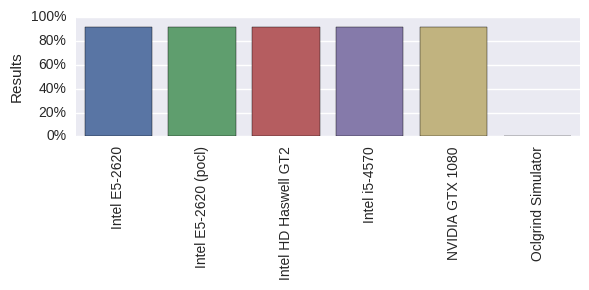

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from labm8 import viz
from operator import itemgetter
%matplotlib inline

# build table of number of number of results for each device+params combination:
# TODO: stacked table based on classification
rows = []
columns = ["Device", "Results"]
for testbed in s.query(Testbed).distinct():
        num_results = s.query(TABLE).filter(TABLE.testbed_id == testbed.id).count()
        rows.append((device_str(testbed.device), num_results / max_results_per_testbed))

ax = sns.barplot(data=pd.DataFrame(sorted(rows, key=itemgetter(0)), columns=columns),
                 x="Device", y="Results")
plt.xlabel("")
plt.ylabel("Results")
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
viz.finalise(figsize=(6,3))

In [5]:
# Table of outcomes per device
rows = []
columns = ["Device", "Outcome", "Count", "% of Results for Device"]

testbeds_with_results = s.query(Testbed).distinct()\
    .join(TABLE, TABLE.testbed_id == Testbed.id).all()

for i, testbed in enumerate(testbeds_with_results):
    nresult = s.query(TABLE)\
        .filter(TABLE.testbed == testbed).count()

    ratios, labels = [], []
    outcomes = s.query(TABLE.outcome, sql.func.count(TABLE.outcome))\
        .filter(TABLE.testbed == testbed).group_by(TABLE.outcome)\
        .order_by(sql.desc(sql.func.count(TABLE.outcome)))

    rows += [(device_str(testbed.device), outcome, count, (count / nresult) * 100)
             for outcome, count in outcomes]

pd.DataFrame(rows, columns=columns)

,Device,Outcome,Count,% of Results for Device
0,NVIDIA GTX 1080,CL_INVALID_KERNEL_ARGS,1008,56.502242
1,NVIDIA GTX 1080,Error setting kernel argument,238,13.340807
2,NVIDIA GTX 1080,z_Okay,228,12.780269
3,NVIDIA GTX 1080,Error building program: -42,198,11.098655
4,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,72,4.035874
5,NVIDIA GTX 1080,Error enqueueing kernel,20,1.121076
6,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,20,1.121076
7,Intel E5-2620,Error enqueueing kernel,1028,57.623318
8,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,272,15.246637
9,Intel E5-2620,Error setting kernel argument,236,13.228700


In [6]:
# Table of classifications per device
rows = []
columns = ["Device", "Classification", "Count", "% of Results for Device"]

testbeds_with_results = s.query(Testbed).distinct()\
    .join(TABLE, TABLE.testbed_id == Testbed.id).all()

for i, testbed in enumerate(testbeds_with_results):
    nresult = s.query(TABLE).filter(TABLE.testbed == testbed).count()

    ratios, labels = [], []
    classifications = s.query(TABLE.classification, sql.func.count(TABLE.classification))\
        .filter(TABLE.testbed == testbed).group_by(TABLE.classification)\
        .order_by(sql.desc(sql.func.count(TABLE.classification)))

    rows += [(device_str(testbed.device), classification, count, "{:.1%}".format(count / nresult))
             for classification, count in classifications]

pd.DataFrame(rows, columns=columns)

,Device,Classification,Count,% of Results for Device
0,NVIDIA GTX 1080,Invalid testcase,1464,82.1%
1,NVIDIA GTX 1080,Okay,205,11.5%
2,NVIDIA GTX 1080,Build failure,92,5.2%
3,NVIDIA GTX 1080,No majority,14,0.8%
4,NVIDIA GTX 1080,Wrong code,9,0.5%
5,Intel E5-2620,Invalid testcase,1264,70.9%
6,Intel E5-2620,Build failure,294,16.5%
7,Intel E5-2620,Okay,212,11.9%
8,Intel E5-2620,No majority,14,0.8%
9,Intel i5-4570,Invalid testcase,1264,70.9%


In [11]:
from collections import Counter


def summarize_cl_launcher_stdout(stdout):
    """
    attempt to shorten output
    """
    if stdout.startswith("[UNKNOWN]"):
        return stdout

    components = [int(x, 0) for x in stdout.split(",") if x != ""]
    if len(components) <= 1:
        return f"'{stdout}'"
    
    buff = []
    counter = 1
    curr = components[0]
    for i in range(1, len(components)):
        if components[i] == curr:
            counter += 1
        else:
            if counter > 1:
                buff.append(f"'{curr},' x {counter}")
            else:
                buff.append(f"'{curr},'")
            counter = 1
            curr = components[i]
    
    if counter > 1:
        buff.append(f"'{curr},' x {counter}")
    else:
        buff.append(f"'{curr},'")    
    return '\n                   '.join(buff)


def generate_report_base(result):
    return f"""\
[Metadata]
Result ID:         {result.id}
Testbed ID:        {result.testbed_id}
Params ID:         {result.params_id}
Program ID:        {result.program_id}

[Testbed]
OpenCL Platform:   {result.testbed.platform}
OpenCL Device:     {result.testbed.device}
Driver version:    {result.testbed.driver}
OpenCL version:    {result.testbed.opencl}
Operating System:  {result.testbed.host}
"""


def generate_wrong_code_report(result):
    results = s.query(cl_launcherCLgenResult)\
        .filter(TABLE.program == result.program,
                TABLE.params == result.params,
                TABLE.status == 0).all()
    
    if len(results) > 2:
        # Use voting to pick oracle.
        outputs = [r.stdout for r in results]
        majority_output, majority_count = Counter(outputs).most_common(1)[0]
    elif len(results) == 2:
        if results[0].stdout != results[1].stdout:
            majority_count = 1
            ndistinct = len(results)
            majority_output = f"[UNKNOWN] ({ndistinct} distinct outputs)"
        else:
            majority_count = 2

    majority_devices = [
        r.testbed for r in results if r.stdout == majority_output
    ]
    minority_devices = [
        r.testbed for r in results if r.stdout != majority_output
    ]
    minority_count = len(minority_devices)
    
    if result.testbed in majority_devices:
        return

    majority_str = "    - " + "\n    - ".join(t.device for t in majority_devices)
    minority_str = "    - " + "\n    - ".join(t.device for t in minority_devices)

    program_output = summarize_cl_launcher_stdout(result.stdout)
    expected_output = summarize_cl_launcher_stdout(majority_output)
    
    return generate_report_base(result) + f"""

[Kernel]
{result.program.src}

[Parameters]    
Global size:       {result.params.gsize}
Workgroup size:    {result.params.lsize}
Optimizations:     {result.params.optimizations_on_off}

[Output]
Program output:    {program_output}
Expected output:   {expected_output}

Majority devices ({majority_count}):
{majority_str}

Minority devices ({minority_count}):
{minority_str}
"""
# Steps to reproduce:
#     $ ./cl_launcher {result.flags}

In [12]:
# Generate wrong-code reports for all *handchecked* programs.
#
# To handcheck programs, run $ cd ../difftest && ./handcheck.py
#
wrong_code_results = s.query(TABLE)\
    .filter(TABLE.classification == "Wrong code")\
    .join(CLgenProgram, CLgenProgram.id == TABLE.program_id)\
    .filter(CLgenProgram.handchecked == 1)

print("#. wrong code reports:", wrong_code_results.count(), "\n")

for result in wrong_code_results:
    report = generate_wrong_code_report(result)
    if report:
        print(report)
        print("***************************************\n")

#. wrong code reports: 3 

[Metadata]
Result ID:         28175
Testbed ID:        3
Params ID:         1
Program ID:        52b2b9edd466664d080e49812c41a7ed0dda3c06

[Testbed]
OpenCL Platform:   NVIDIA CUDA
OpenCL Device:     GeForce GTX 1080
Driver version:    375.39
OpenCL version:    1.2
Operating System:  Ubuntu 16.04 64bit


[Kernel]
__kernel void entry(__global int* a) {
  a[get_local_id(0)] = get_global_id(0);

  barrier(1);
}

[Parameters]    
Global size:       (128, 16, 1)
Workgroup size:    (32, 1, 1)
Optimizations:     on

[Output]
Program output:    '279172874304,'
                   '287762808898,'
                   '296352743492,'
                   '304942678086,'
                   '313532612680,'
                   '322122547274,'
                   '330712481868,'
                   '339302416462,'
                   '347892351056,'
                   '356482285650,'
                   '365072220244,'
                   '373662154838,'
                   '3822520894